# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

2 kinds of tasks:
- learn to adapt the backward weights to transpose of forward weights <<< this notebook
- learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of L-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

# Learn $B = W^T$ in tiny net

We add tiny noise to the hidden layer in a network [1-2-1] and learn the backwards weights to align with $(W^\mathrm{PP})^T$.

In particular, to make it easier to identify if the task is performed succesfully, we initialise $B^\mathrm{PP}$ with negative entries, and $(W^\mathrm{PP})^T$ with positive values.

### Setup

In [35]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = dt # after how many steps to sample new noise
tauxi  = 10 * dtxi # time constant of Ornstein-Uhlenbeck noise
tauHP  = 10 * dtxi # time constant of high-pass filter
tauLO  = 10 * dtxi # time constant of low-pass filter -- doesn't matter here, as no forward weights are learnt
Tpres  = 1e+3 * dt # present images for 1 ms
Ttot   = 200 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [5e-2]

np.random.seed(12345)

# Init model: weights, voltages

layers = [1, 2, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [500.0] * (len(layers) - 2)
eta_IP = [20.0] * (len(layers) - 1)
eta_PI = [1.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [5e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# instantiate the model

mc1 = noise_model(bw_connection_mode='layered',
                  dt=dt, dtxi=dtxi, tauxi=tauxi, tauHP=tauHP, tauLO=tauLO, Tpres=Tpres,
                  noise_type='OU', noise_scale=noise_scale,
                  alpha=alpha,
                  inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=True, dWPP_r_low_pass=False, dWPP_post_low_pass=False, gate_regularizer=False, dWPP_use_activation=True,
                  noise_mode='uP', model='PAL',
                  activation=relu, layers=layers,
                  uP_init=uP_init, uI_init=uI_init,
                  WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                  gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                  eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

### Simulation

In [36]:
# # pre-training to settle voltages
# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [37]:
mc1.init_record(rec_per_steps=10, rec_WPP=True, rec_WIP=True, rec_BPP=True, rec_BPI=True, rec_rI_breve=True, rec_rP_breve=True, rec_vapi=True)

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_lat_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP

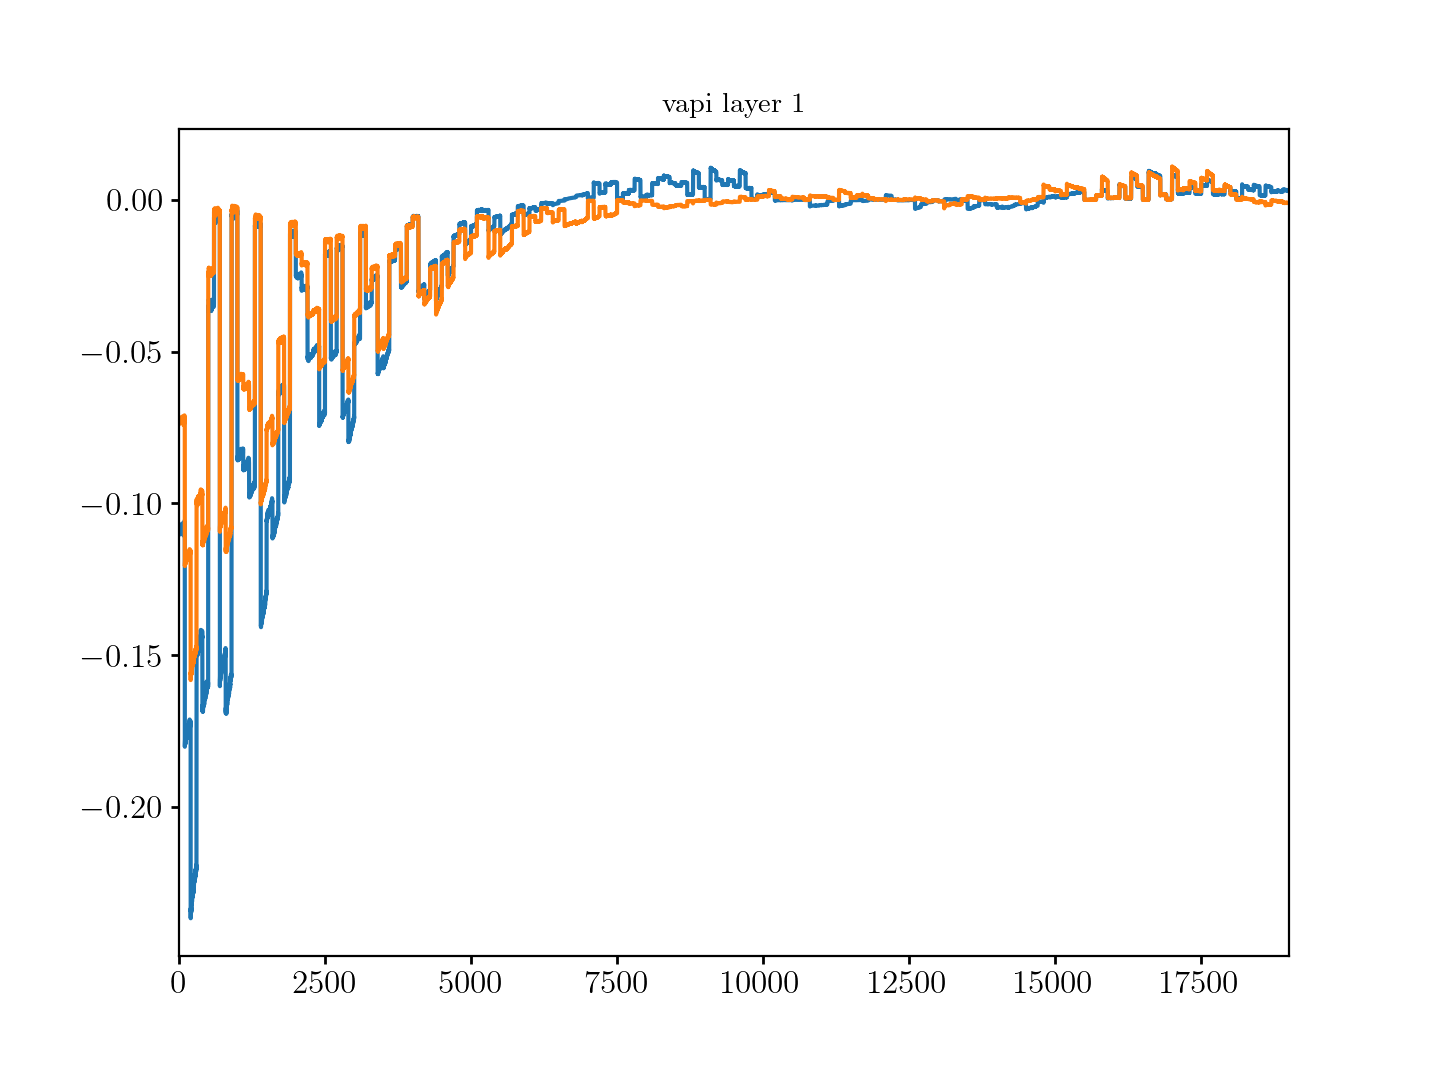

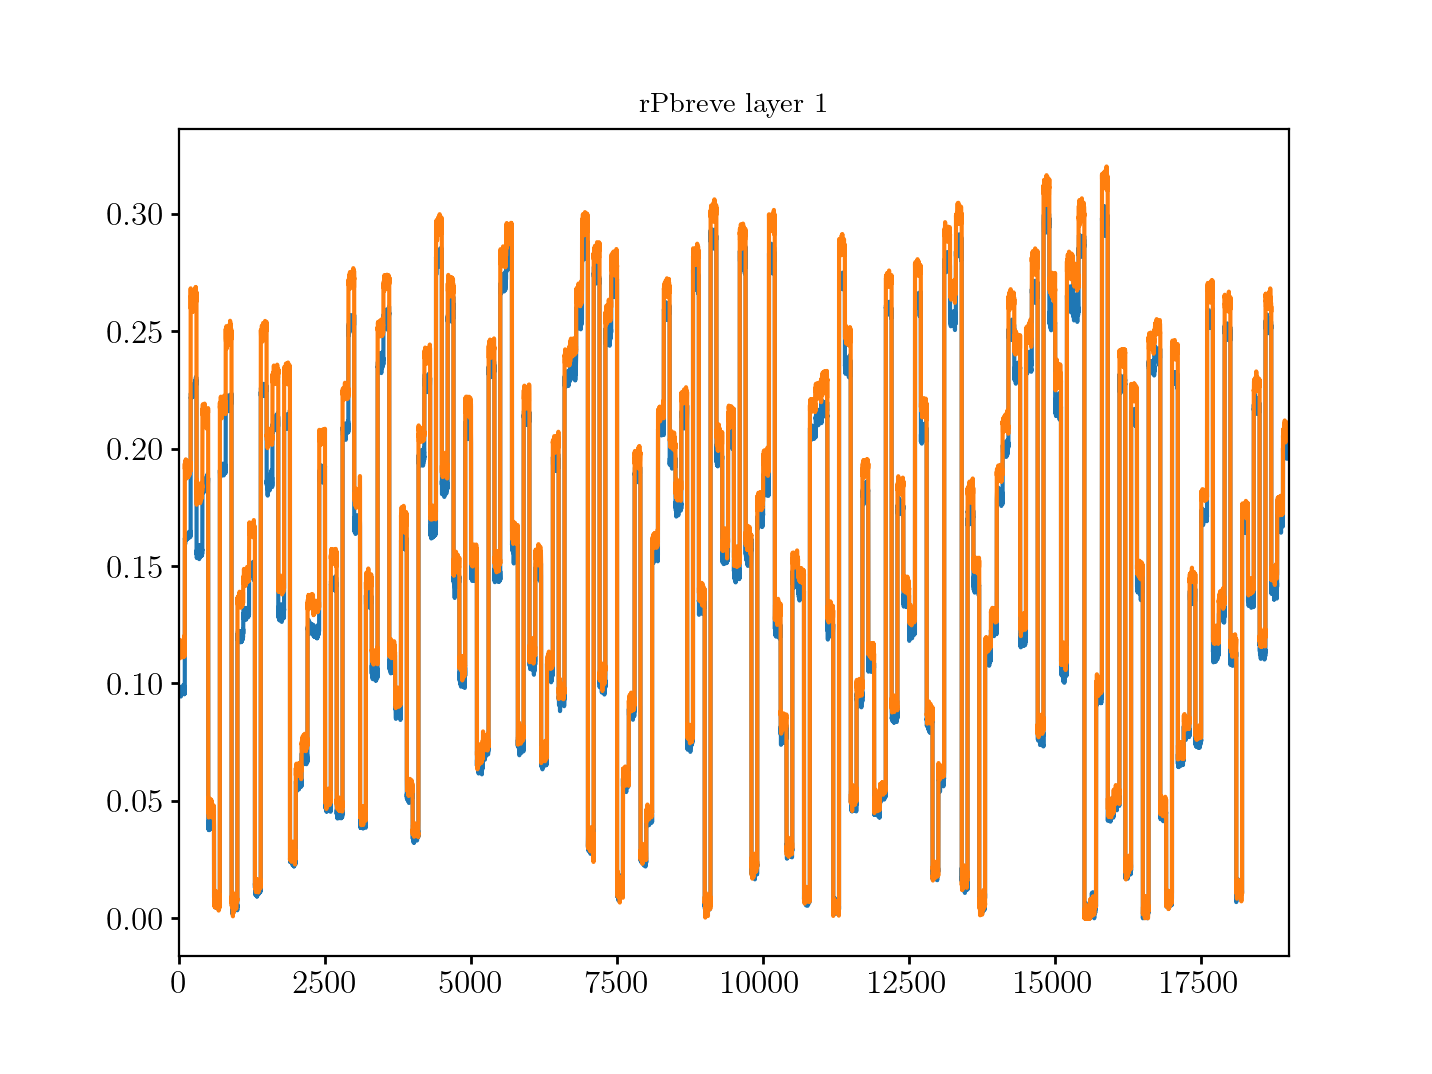

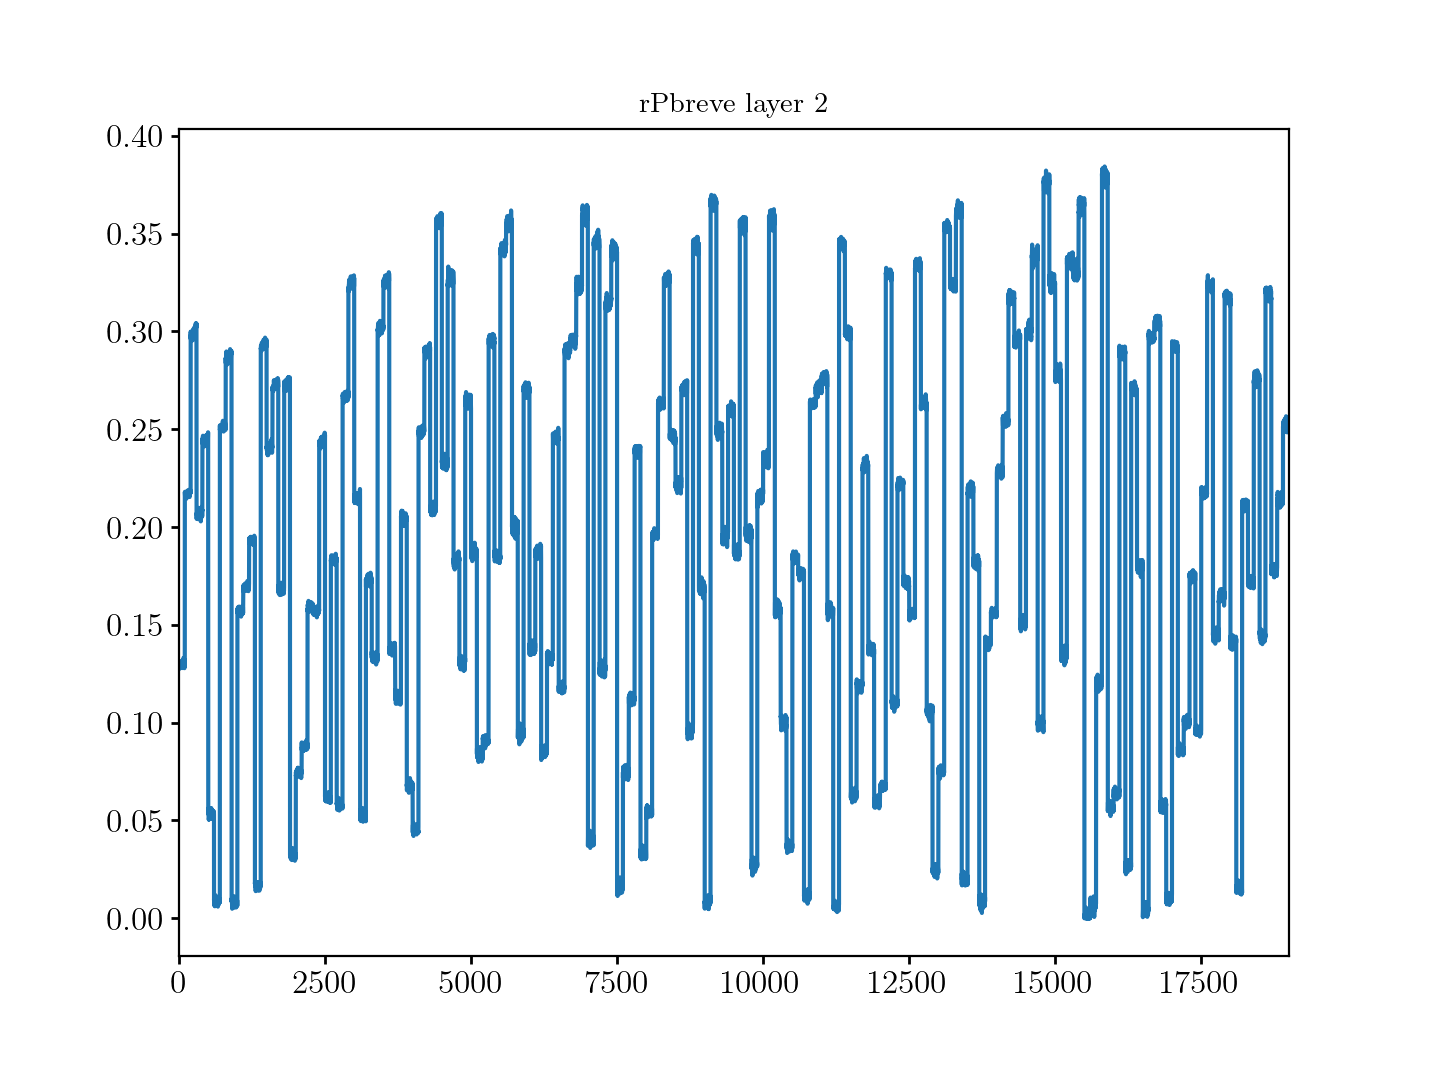

In [38]:
fig = plt.figure()
for i in range(len(mc1.vapi_time_series[0][0])):
    vec = [vec[0][i] for vec in mc1.vapi_time_series]
    plt.plot(np.array(vec[int(Tpres/dt):]).ravel())
plt.title("vapi layer 1")
plt.show()

fig = plt.figure()
for i in range(len(mc1.rP_breve_time_series[0][0])):
    vec = [vec[0][i] for vec in mc1.rP_breve_time_series]
    plt.plot(np.array(vec[int(Tpres/dt):]).ravel())
plt.title("rPbreve layer 1")
plt.show()

fig = plt.figure()
for i in range(len(mc1.rP_breve_time_series[0][1])):
    vec = [vec[1][i] for vec in mc1.rP_breve_time_series]
    plt.plot(np.array(vec[int(Tpres/dt):]).ravel())
plt.title("rPbreve layer 2")
plt.show()

Check that BPP and BPI learn at ~ same speed:

In [39]:
print(mc1.dWIP[0])
print(mc1.dBPP[0].T)
print(mc1.dBPI[0].T)

[[7.14801588e-07 7.26671244e-07]]
[[-1.85186672e-06  7.21771287e-06]]
[[-7.77184676e-07  2.44148695e-07]]


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [40]:
STEPS = 1

mc1.cos_BPI_BPP = []
for i in range(len(mc1.BPI_time_series[0])):
    mc1.cos_BPI_BPP.append(np.array([
        cos_sim(mc1.BPI_time_series[j][i], -mc1.BPP_time_series[j][i]) for j in range(0, len(mc1.BPI_time_series), STEPS)
                           ]))
    
mc1.cos_WIP_WPP = []
for i in range(len(mc1.WIP_time_series[0])):
    mc1.cos_WIP_WPP.append(np.array([
        cos_sim(mc1.WIP_time_series[j][i], mc1.WPP_time_series[j][i+1]) for j in range(0, len(mc1.WIP_time_series), STEPS)
                           ]))
    
mc1.cos_WPPtrans_BPP = []
for i in range(len(mc1.BPP_time_series[0])):
    mc1.cos_WPPtrans_BPP.append(np.array([
        cos_sim(mc1.BPP_time_series[j][i], mc1.WPP_time_series[j][i+1].T) for j in range(0, len(mc1.BPP_time_series), STEPS)
                           ]))

BPP at init:

In [41]:
mc1.BPP_time_series[0][0]

array([[-0.25341632],
       [-0.03769726]])

BPP after learning:

In [42]:
mc1.BPP_time_series[-1][0]

array([[0.06284681],
       [0.06784516]])

WPP^T (fixed):

In [43]:
mc1.WPP_time_series[0][1].T

array([[0.96451452],
       [0.6531771 ]])

Plot cos between $B$ and $W^T$, and actual entries (Note: the algorithm only *aligns* $B$ with $W^T$ -- it doesn't also set it to the same scale.)

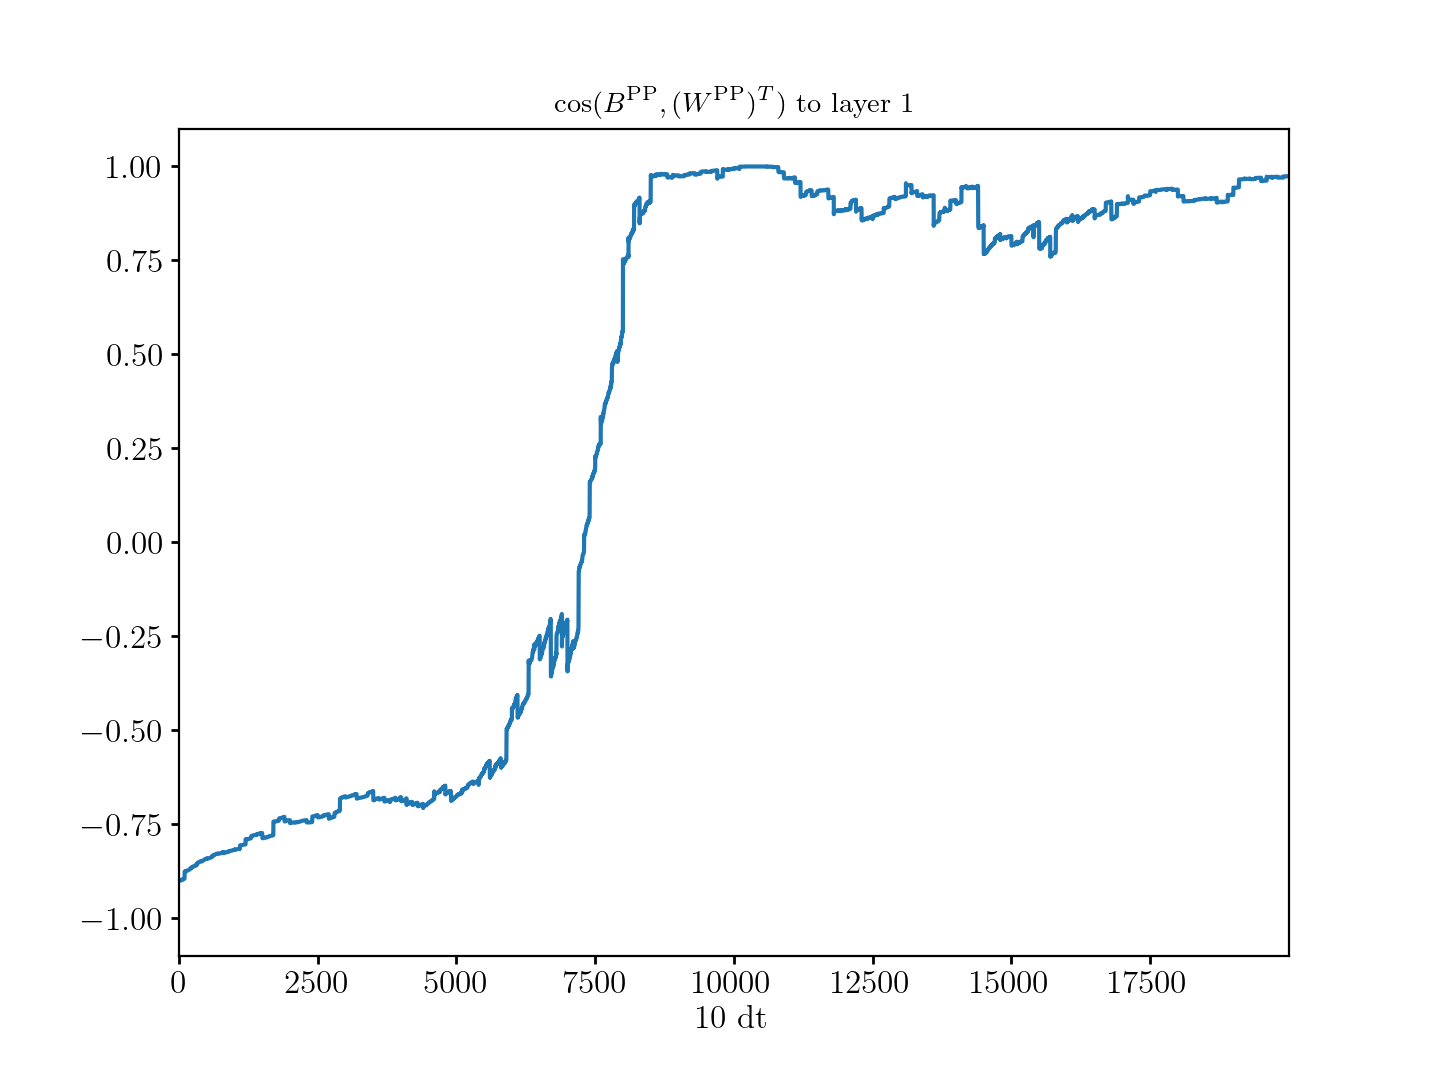

/var/folders/zb/q43ry99x69g19b1w0cyrrr700000gn/T/ipykernel_83992/2087578439.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


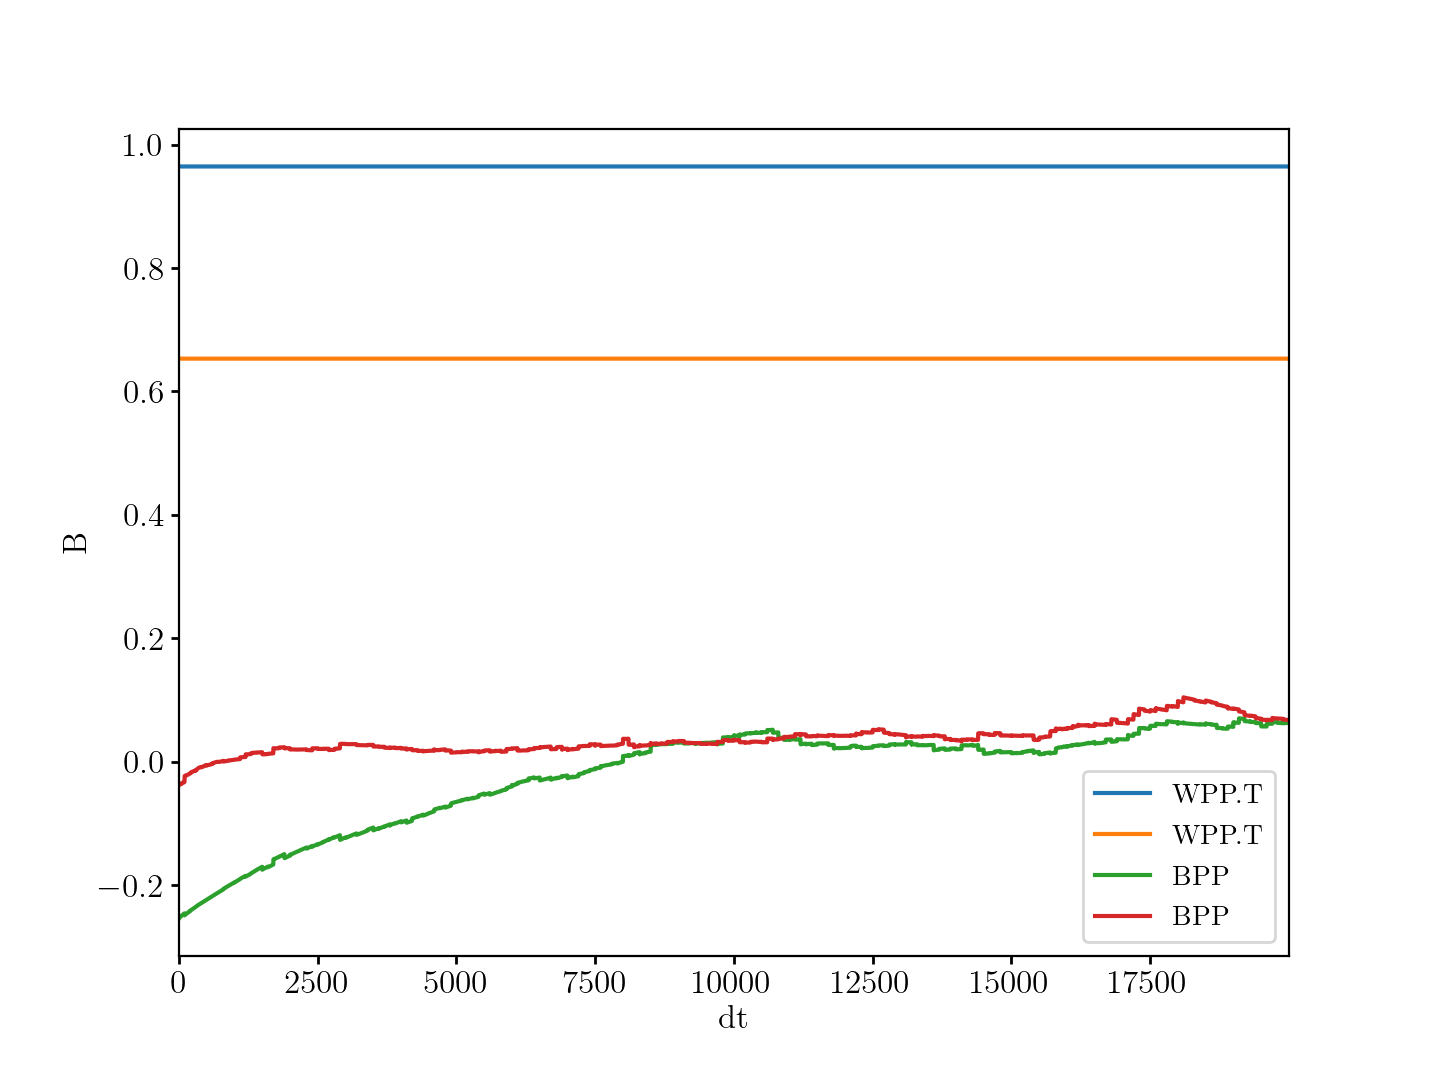

In [44]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in mc1.WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in mc1.BPP_time_series], label="BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We also check if the self-predicting state has been learnt correctly:

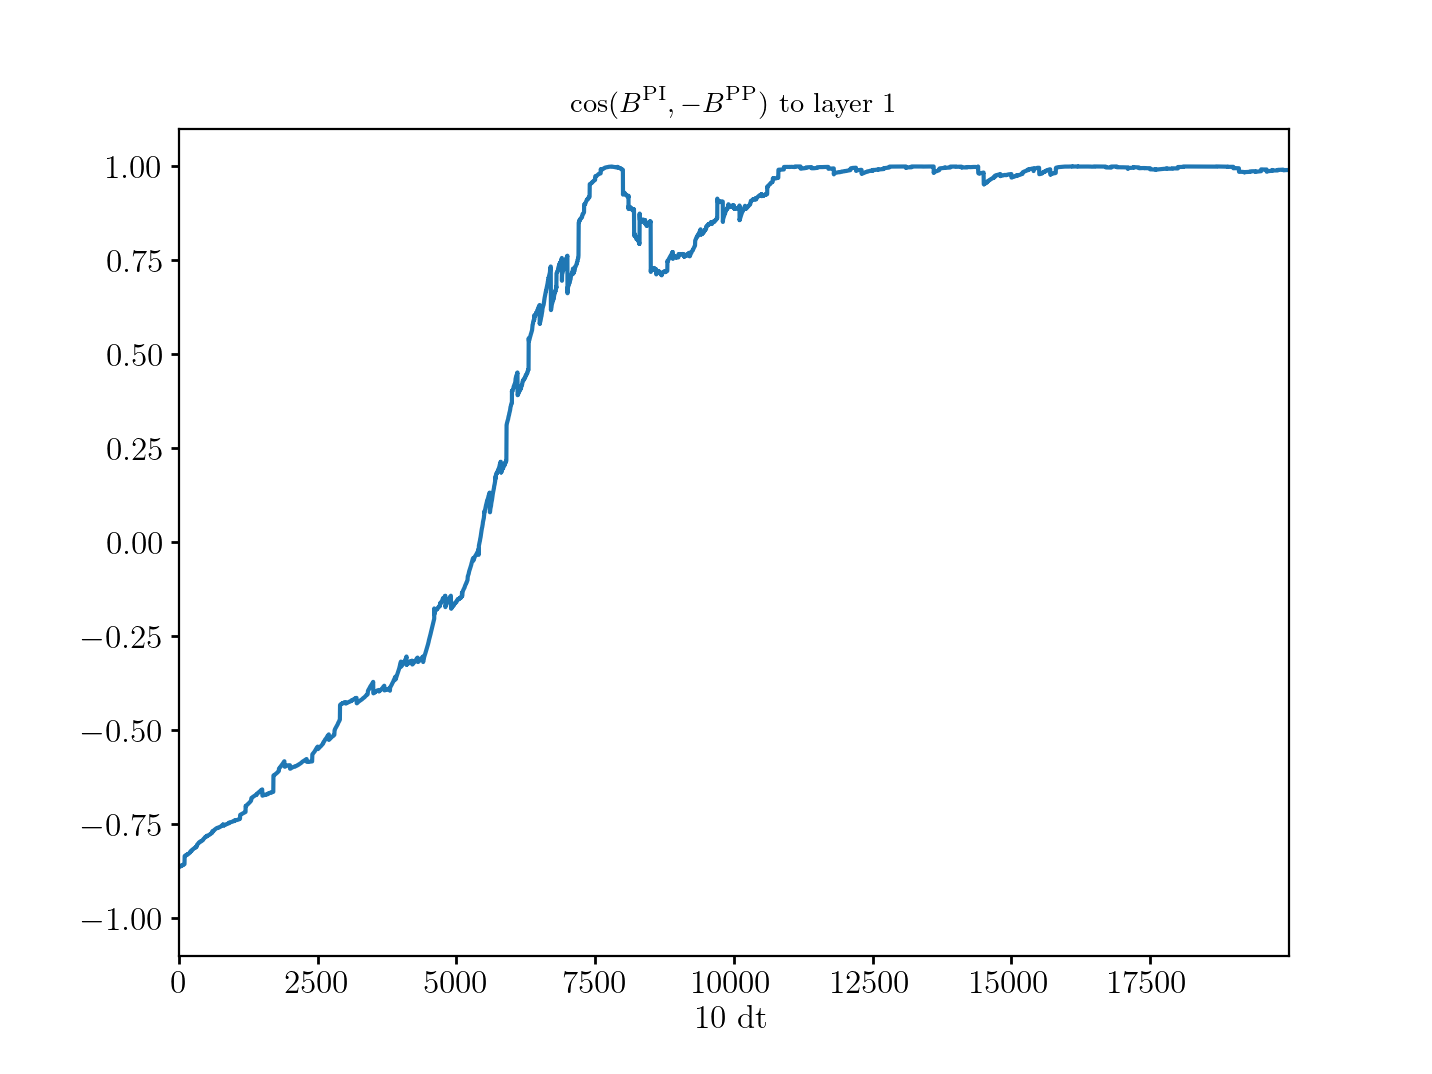

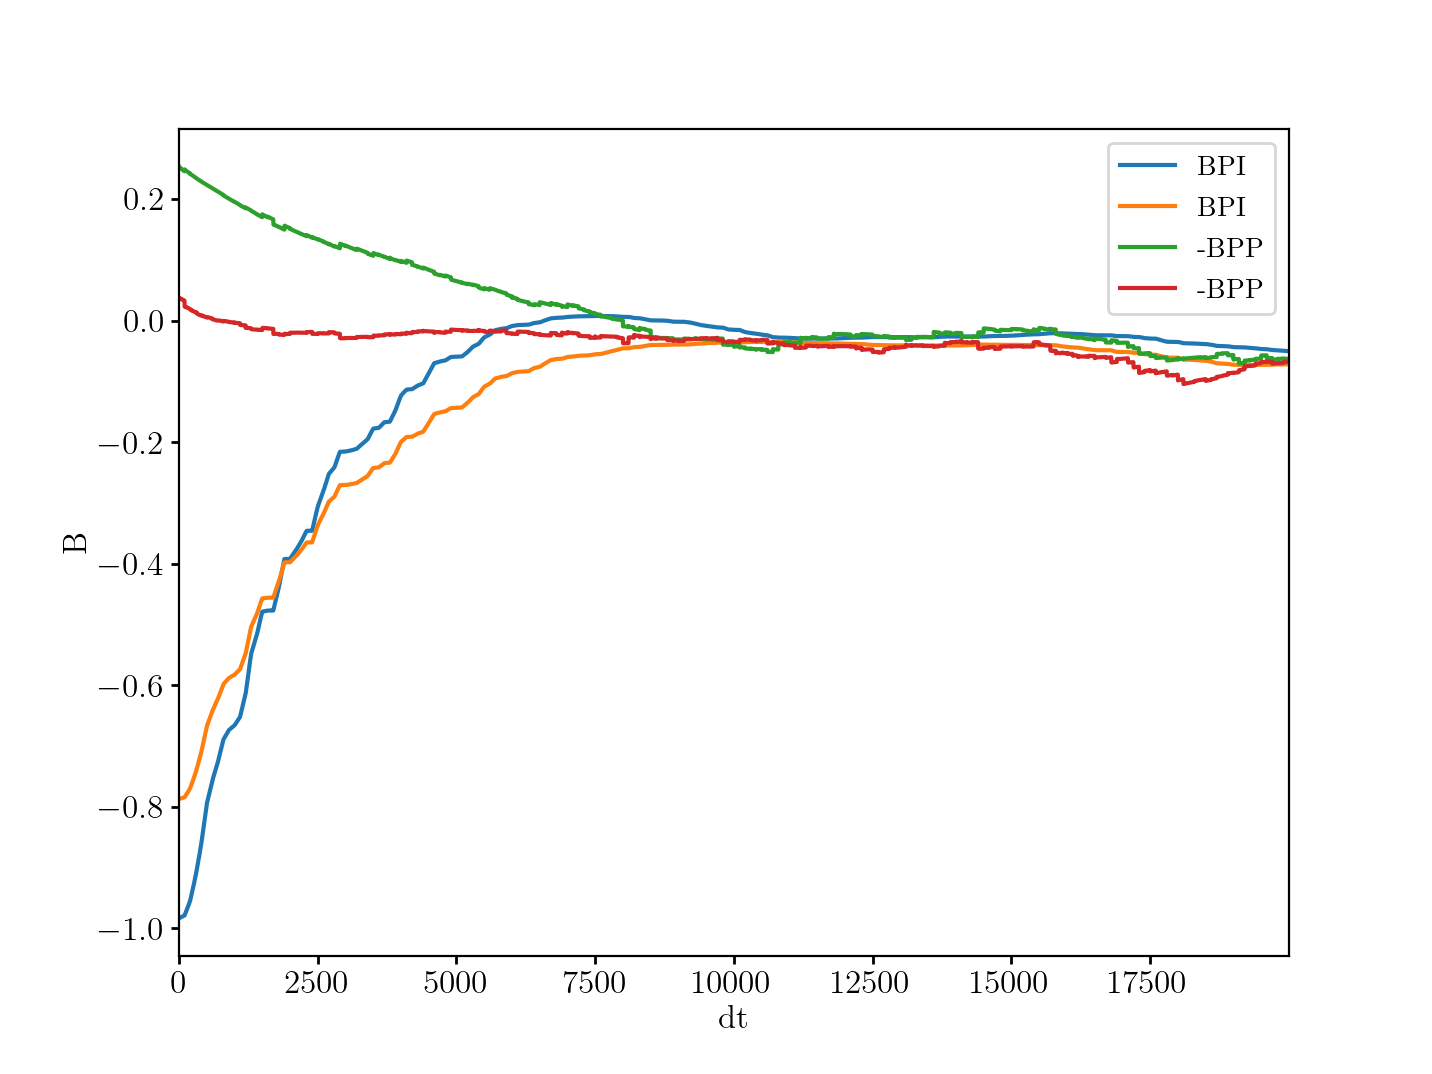

In [45]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc1.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc1.BPP_time_series], label="-BPP")
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

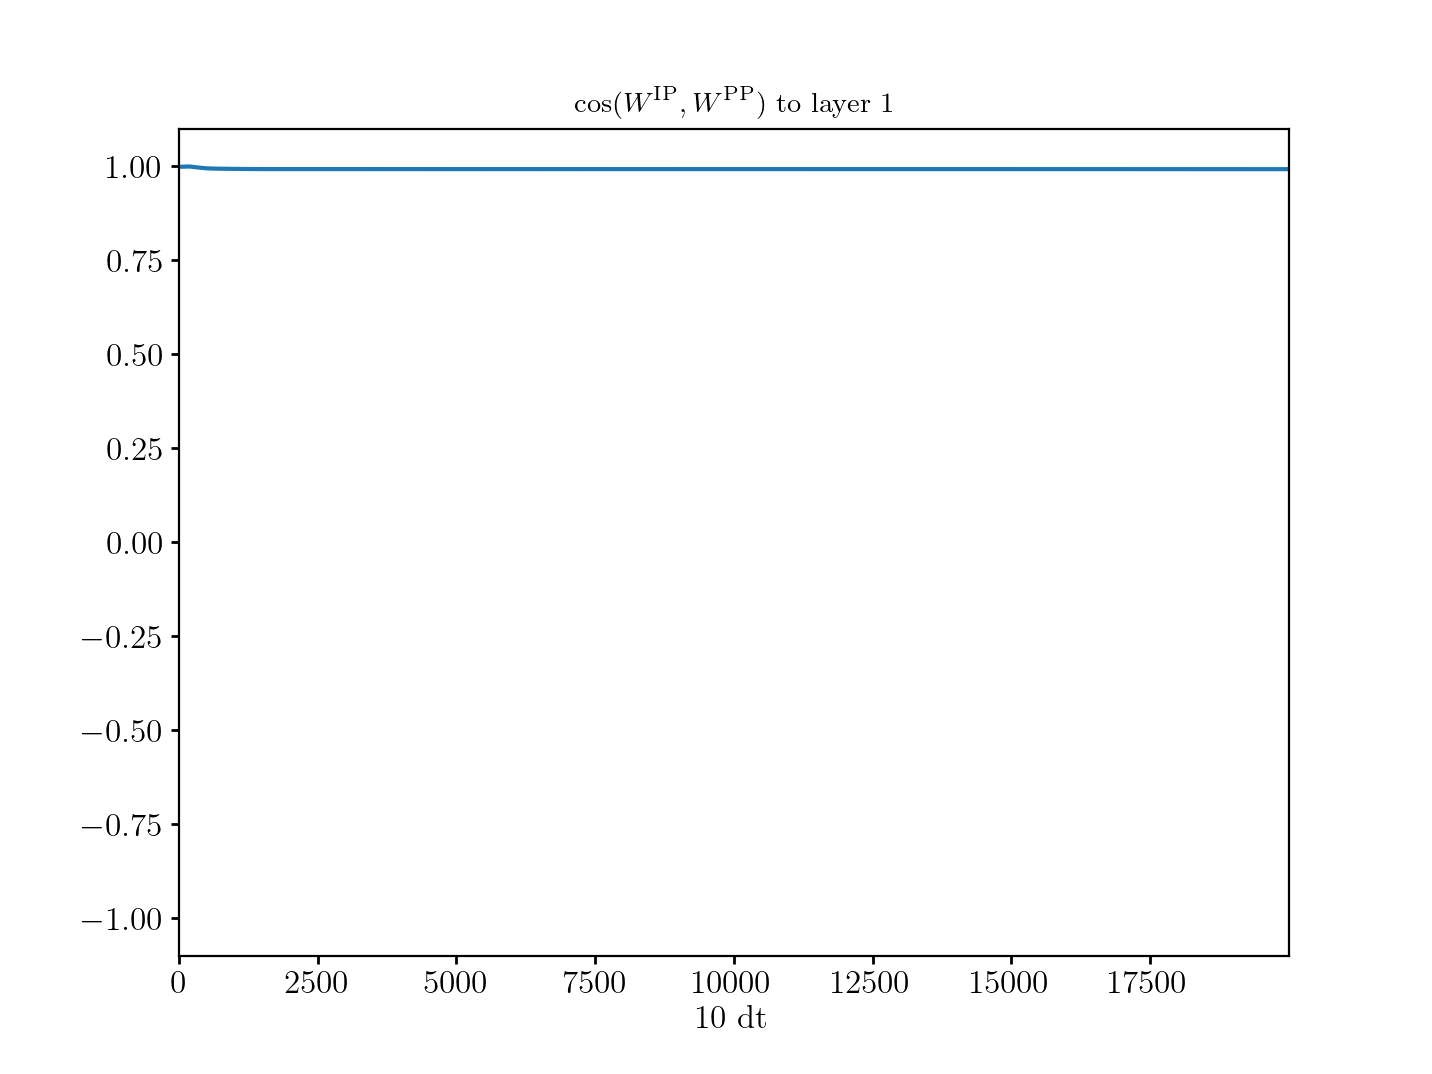

In [46]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WIP_WPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

# Learn $B = W^T$ in small net

We repeat the above procedure for a slightly larger net: [2-2-2].

In this case, we initialise in the self-predicting state.

### Setup

In [2]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = dt # after how many steps to sample new noise
tauxi  = 10 * dtxi # time constant of Ornstein-Uhlenbeck noise
tauHP  = 10 * dtxi # time constant of high-pass filter
tauLO  = 10 * dtxi # time constant of low-pass filter -- doesn't matter here, as no forward weights are learnt
Tpres  = 1e+3 * dt # present images for 1 ms
Ttot   = 200 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [5e-2]

np.random.seed(12345)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [200.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # not needed, as we init in self-predicting state
eta_PI = [5.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [noise_scale[0]**2 / 10]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

mc2 = noise_model(bw_connection_mode='layered',
                  dt=dt, dtxi=dtxi, tauxi=tauxi, tauHP=tauHP, tauLO=tauLO, Tpres=Tpres,
                  noise_type='OU', noise_scale=noise_scale,
                  alpha=alpha,
                  inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=True, dWPP_r_low_pass=False, dWPP_post_low_pass=False, gate_regularizer=False, dWPP_use_activation=True,
                  noise_mode='uP', model='PAL',
                  activation=relu, layers=layers,
                  uP_init=uP_init, uI_init=uI_init,
                  WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                  gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                  eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2.set_self_predicting_state()

### Simulation

In [3]:
# # pre-training to settle voltages
# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [4]:
mc2.init_record(rec_per_steps=10, rec_WPP=True, rec_WIP=False, rec_BPP=True, rec_BPI=True)

for i in range(len(r0_random)):
    mc2.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt BPI and BPP

Check that BPP and BPI learn at ~ same speed:

In [5]:
print(mc2.dBPP[0].T)
print(mc2.dBPI[0].T)

[[-4.03351297e-06  2.78486972e-05]
 [-1.23804963e-07  2.36062745e-06]]
[[ 2.36933155e-06 -5.95881998e-06]
 [ 1.53914838e-07 -3.87092643e-07]]


Now, let's also check that BPI has converged onto -BPP and BPP onto WPP.T:

In [6]:
mc2.cos_BPI_BPP = []
for i in range(len(mc2.BPI_time_series[0])):
    mc2.cos_BPI_BPP.append(np.array([
        cos_sim(mc2.BPI_time_series[j][i], -mc2.BPP_time_series[j][i]) for j in range(0, len(mc2.BPI_time_series))
                           ]))
    
mc2.cos_WPPtrans_BPP = []
for i in range(len(mc2.BPP_time_series[0])):
    mc2.cos_WPPtrans_BPP.append(np.array([
        cos_sim(mc2.BPP_time_series[j][i], mc2.WPP_time_series[j][i+1].T) for j in range(0, len(mc2.BPP_time_series))
                           ]))

BPP at init:

In [7]:
mc2.BPP_time_series[0][0]

array([[-0.03976523, -0.27647605],
       [-0.35701339, -0.28234671]])

BPP after learning:

In [8]:
mc2.BPP_time_series[-1][0]

array([[0.05822141, 0.00049973],
       [0.03966429, 0.00532068]])

WPP^T (fixed):

In [9]:
mc2.WPP_time_series[0][1].T

array([[0.74771481, 0.0083883 ],
       [0.96130674, 0.10644438]])

Plot cos between $B$ and $W^T$, and actual entries (Note: the algorithm only *aligns* $B$ with $W^T$ -- it doesn't also set it to the same scale.)

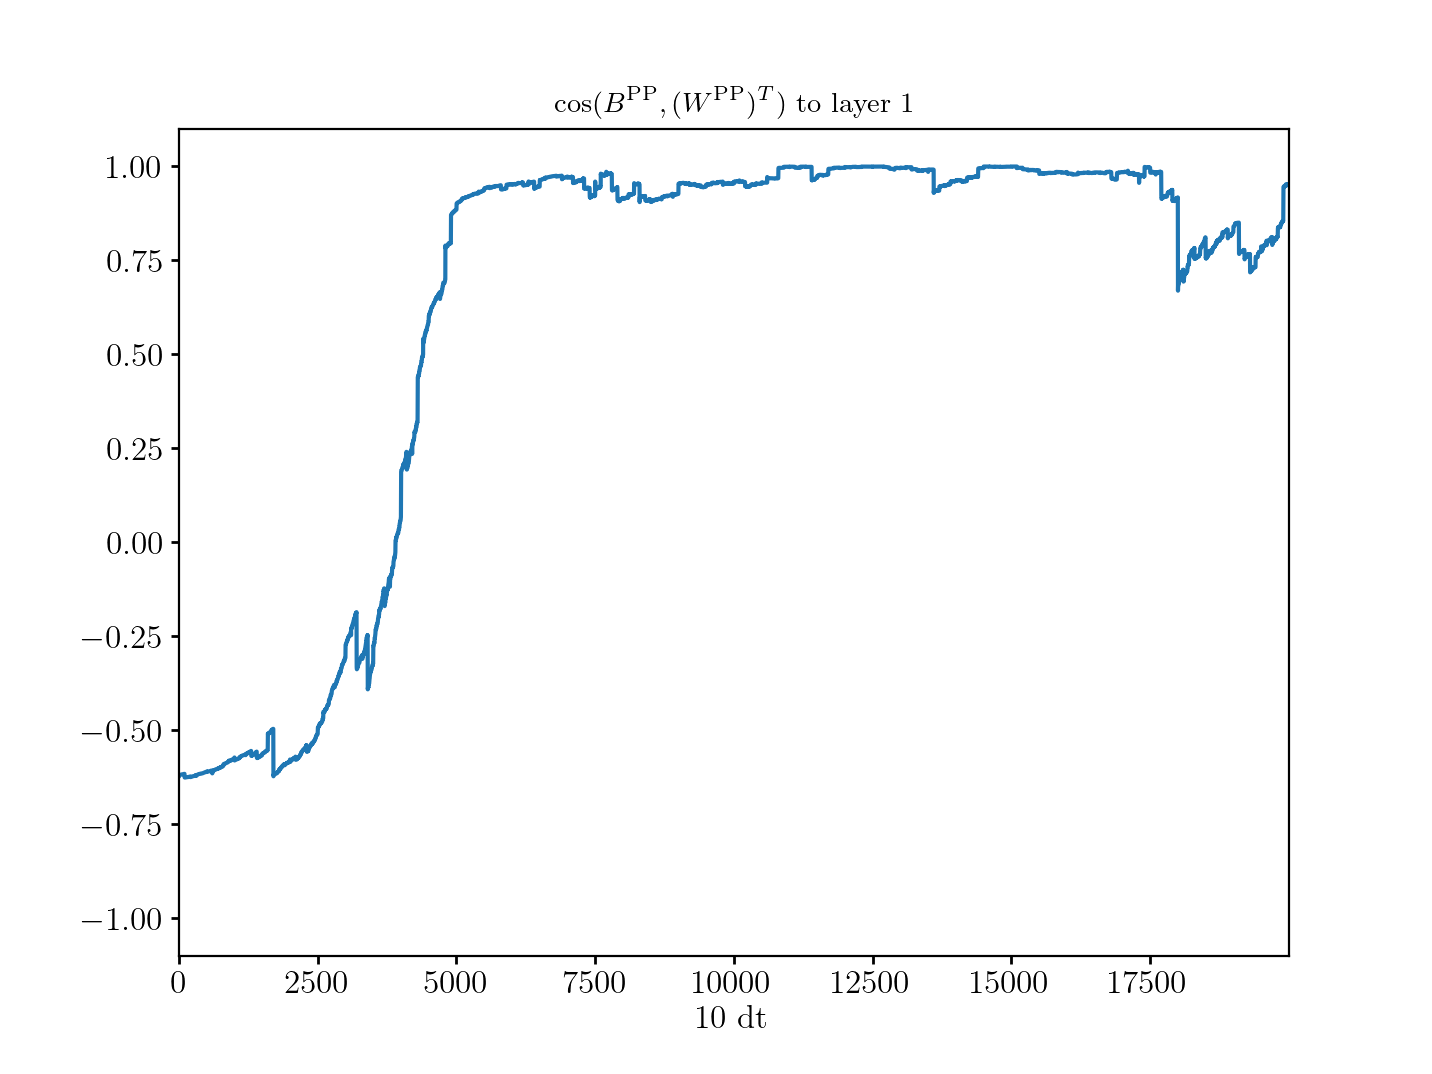

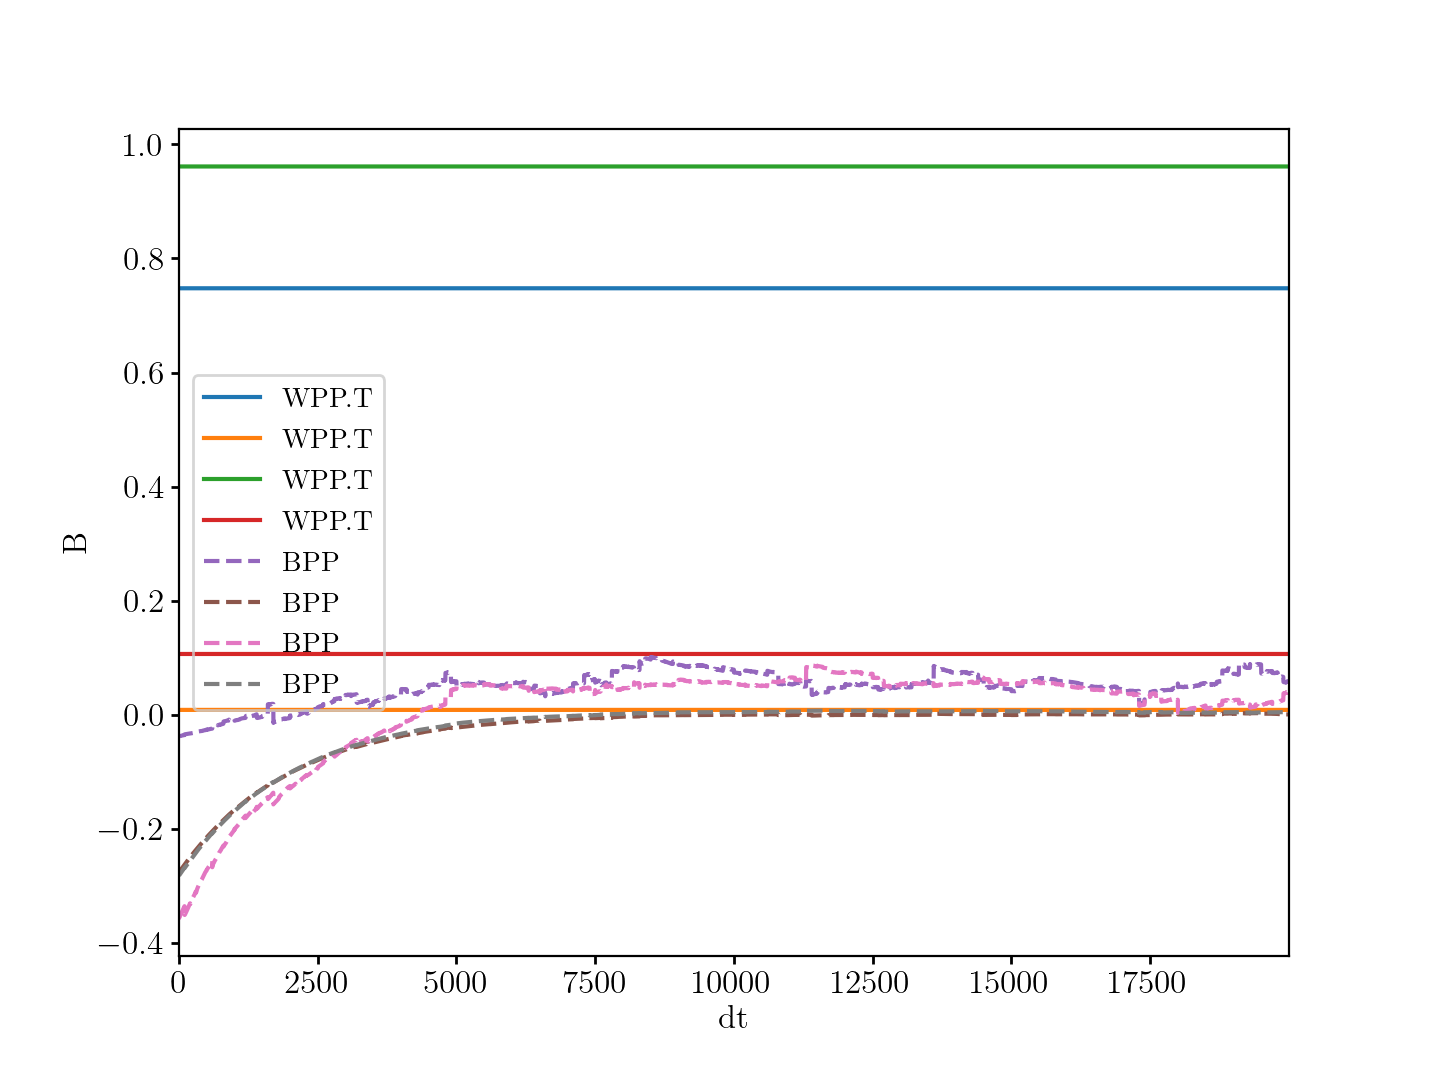

In [10]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc2.cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.plot([WPP[i+1].T.ravel() for WPP in mc2.WPP_time_series], label="WPP.T")
    ax.plot([BPP[i].ravel() for BPP in mc2.BPP_time_series], label="BPP", ls='--')
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We also check if the self-predicting state has been learnt correctly:

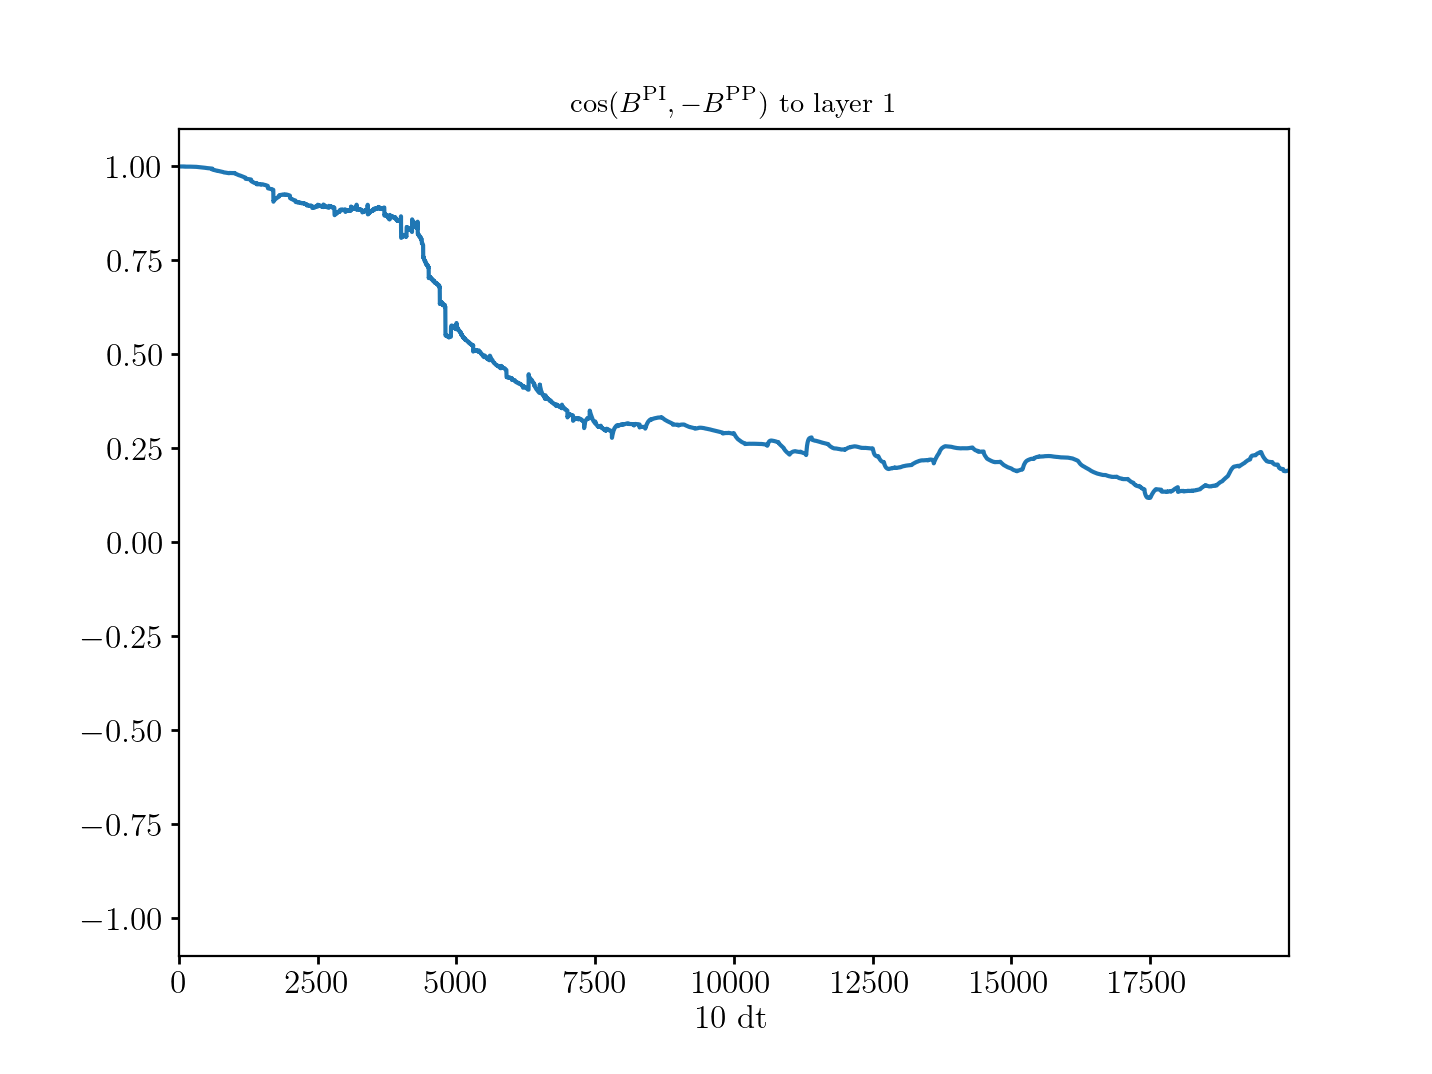

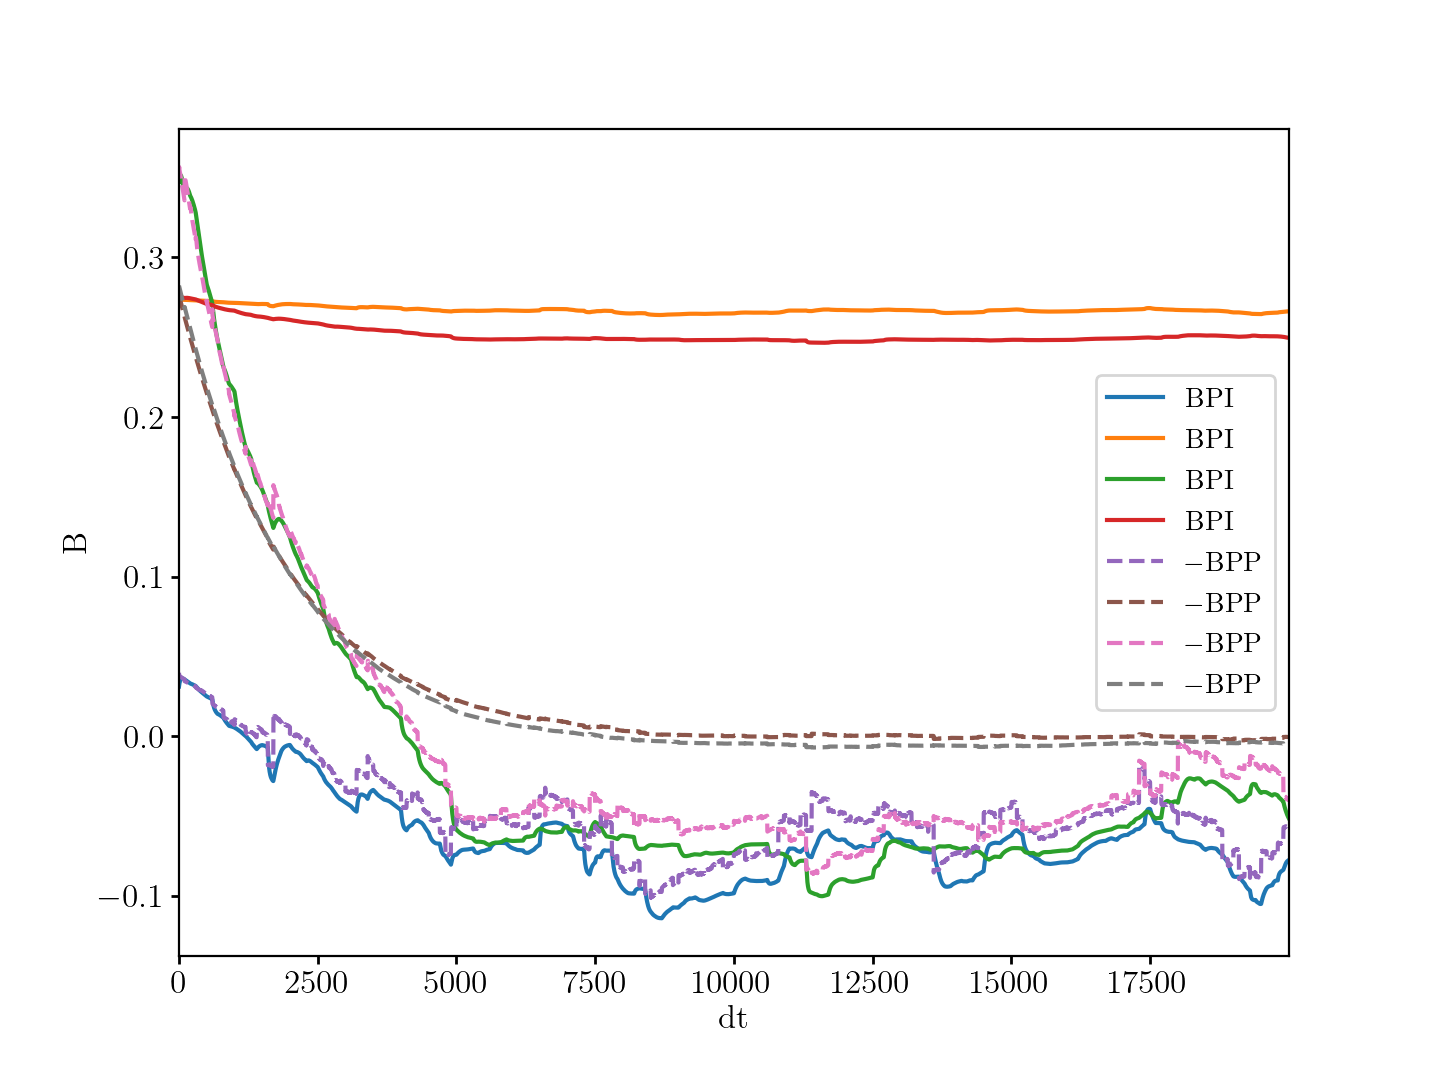

In [11]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc2.cos_BPI_BPP[i])
    plt.yscale('linear')
    label = '10 dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc2.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc2.BPP_time_series], label="$-$BPP", linestyle='--')
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We see that the SPS is not held exactly. Why is this?

> The learning rule only seeks to minimize vapi. For the SPS, we need rP_breve = rI_breve (up to error signal, which is 0 here) and that BPP @ rP_breve = - BPI @ rI_breve. Let's check whether these two conditions hold:

In [12]:
print(mc2.rP_breve[-1], mc2.rI_breve[-1])

[0.4963375  0.03213464] [0.49661269 0.03217879]


In [13]:
mc2.BPP[-1] @ mc2.rP_breve[-1] + mc2.BPI[-1] @ mc2.rI_breve[-1]

array([-0.0010539 ,  0.00236558])

So the reason that BPP != - BPP is that the learning rule has found *a* self-predicting state, just not *the* SPS.